In [16]:
from my_import import *
df_train = pd.read_csv('df_train.csv')
df_val = pd.read_csv('df_val.csv')
df_test = pd.read_csv('df_test.csv')
df_full = pd.read_csv('final_cleaned_dataset_df.csv')

#Make sure the genre collumns is in lists not strings
#NEED TO DO THIS EVERYTIME EXPORT DATASET
df_train['genres'] = df_train['genres'].apply(lambda x: list(ast.literal_eval(x)))
df_val['genres'] = df_val['genres'].apply(lambda x: list(ast.literal_eval(x)))
df_test['genres'] = df_test['genres'].apply(lambda x: list(ast.literal_eval(x)))

df_train=df_train.drop(columns=['title','index'])
df_val=df_val.drop(columns=['title','index'])
df_test=df_test.drop(columns=['title','index'])


display(df_train)


,synopsis,genres
0,Shuramaru is hated and feared by the villagers...,[Supernatural]
1,"Sometime in the future, the world was complete...","[Action, Adventure]"
2,"Set in 2014, the anime follows the adventures ...",[Comedy]
3,"This story is about Mick, a sleeping chironomi...",[Adventure]
4,The anime is based on MegaHouse's line of Zigu...,"[Action, Mecha]"
...,...,...
7115,Picture Drama episodes included in each DVD vo...,"[Action, Adventure, Comedy, Drama, Fantasy, Ro..."
7116,"On a hot summer day, Takashi Natsume and his f...","[Drama, Shoujo, Slice of Life, Supernatural]"
7117,"Due to the arrival of aliens called the ""Amant...","[Action, Comedy, Historical, Mecha, Sci-Fi, Sh..."
7118,The Konohagakure Grand Sports Festival has beg...,"[Action, Comedy, Fantasy, Shounen, Sports]"


In [17]:
# Flatten all genre lists into one long list
all_genres = [genre for sublist in df_train["genres"] for genre in sublist]

# Convert to a set to get unique values
unique_genres = sorted(set(all_genres))

# Print results
print("Number of unique genres:", len(unique_genres))
print("Unique genres:", unique_genres)

Number of unique genres: 20
Unique genres: ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Historical', 'Kids', 'Mecha', 'Music', 'Mystery', 'Romance', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shounen', 'Slice of Life', 'Sports', 'Super Power', 'Supernatural']


In [3]:
# Stack all label rows (e.g., from df_train)
all_labels = np.stack(df_train["labels"].values)

# Compute frequency
label_freq = all_labels.sum(axis=0)
total_samples = len(df_train)

# Inverse frequency weighting
class_weights = total_samples / (label_freq + 1e-6)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights / class_weights.sum()
class_weights=class_weights.to("cuda")
class_weights

KeyError: 'labels'

In [18]:
# ========== STEP 1: Setup & Data Prep ==========
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
from sklearn.metrics import (
    f1_score, jaccard_score, hamming_loss, accuracy_score,precision_score, recall_score
)
import torch
from torch.nn import BCEWithLogitsLoss

# Confirm GPU availability
print("GPU available:", torch.cuda.is_available())
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# ========== STEP 2: Label Setup ==========
# Assuming df_train, df_val, df_test exist and contain "synopsis" and "genres" columns
all_genres = sorted(set(genre for sublist in df_train["genres"] for genre in sublist))
label2id = {genre: idx for idx, genre in enumerate(all_genres)}
id2label = {idx: genre for genre, idx in label2id.items()}
num_labels = len(label2id)

def encode_labels(genres):
    vec = np.zeros(num_labels, dtype=np.float32)
    for genre in genres:
        vec[label2id[genre]] = 1.0
    return vec

df_train["labels"] = df_train["genres"].apply(encode_labels)
df_val["labels"] = df_val["genres"].apply(encode_labels)
df_test["labels"] = df_test["genres"].apply(encode_labels)


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

df_train['clean_synopsis'] = df_train['synopsis'].apply(clean_text)
df_val['clean_synopsis'] = df_val['synopsis'].apply(clean_text)
df_test['clean_synopsis'] = df_test['synopsis'].apply(clean_text)

display(df_train)

GPU available: True
Using device: NVIDIA GeForce GTX 1650


,synopsis,genres,labels,clean_synopsis
0,Shuramaru is hated and feared by the villagers...,[Supernatural],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",shuramaru hated feared villager unusual power ...
1,"Sometime in the future, the world was complete...","[Action, Adventure]","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sometime future world completely dried became ...
2,"Set in 2014, the anime follows the adventures ...",[Comedy],"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",set anime follows adventure year old mafuneko ...
3,"This story is about Mick, a sleeping chironomi...",[Adventure],"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",story mick sleeping chironomid insect taken sp...
4,The anime is based on MegaHouse's line of Zigu...,"[Action, Mecha]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",anime based megahouse line ziguru hazeru liter...
...,...,...,...,...
7115,Picture Drama episodes included in each DVD vo...,"[Action, Adventure, Comedy, Drama, Fantasy, Ro...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",picture drama episode included dvd volume zero...
7116,"On a hot summer day, Takashi Natsume and his f...","[Drama, Shoujo, Slice of Life, Supernatural]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",hot summer day takashi natsume feline companio...
7117,"Due to the arrival of aliens called the ""Amant...","[Action, Comedy, Historical, Mecha, Sci-Fi, Sh...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",due arrival alien called amanto samurai feudal...
7118,The Konohagakure Grand Sports Festival has beg...,"[Action, Comedy, Fantasy, Shounen, Sports]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",konohagakure grand sport festival begun ninja ...


In [15]:
list(thresholds)

[0.45000000000000007,
 0.30000000000000004,
 0.25,
 0.45000000000000007,
 0.30000000000000004,
 0.25,
 0.30000000000000004,
 0.35,
 0.25,
 0.30000000000000004,
 0.45000000000000007,
 0.4,
 0.4,
 0.30000000000000004,
 0.2,
 0.4,
 0.45000000000000007,
 0.2,
 0.5,
 0.30000000000000004]

In [9]:
train_dataset.save_to_disk("path/to/train_dataset")
val_dataset.save_to_disk("path/to/val_dataset")
test_dataset.save_to_disk("path/to/test_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/7120 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 891/891 [00:00<00:00, 89006.71 examples/s] 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#FUNCTION FOR FOCAL LOSS

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        # Binary cross-entropy with logits
        bce_loss = F.binary_cross_entropy_with_logits(
            logits, targets.float(), pos_weight=self.pos_weight, reduction='none'
        )

        # Get probabilities
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)

        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

#implementation
loss_fn = FocalLoss(gamma=2.0, alpha=1.0, pos_weight=class_weights.to(logits.device))
loss = loss_fn(logits, labels.float().to(logits.device))


In [29]:
#SOFT F1 LOSS
import torch
import torch.nn as nn
import torch.nn.functional as F
class SoftF1Loss(nn.Module):
    def __init__(self, epsilon=1e-7, reduction="mean"):
        super(SoftF1Loss, self).__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, logits, labels):
        probs = torch.sigmoid(logits)
        y_true = labels.float()
        y_pred = probs

        tp = (y_pred * y_true).sum(dim=0)
        fp = (y_pred * (1 - y_true)).sum(dim=0)
        fn = ((1 - y_pred) * y_true).sum(dim=0)

        soft_f1 = (2 * tp + self.epsilon) / (2 * tp + fp + fn + self.epsilon)
        loss = 1 - soft_f1

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

#how to use it
loss_fn = SoftF1Loss()
loss = loss_fn(logits, labels.float().to(logits.device))

NameError: name 'logits' is not defined

In [ ]:
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
    attention_probs_dropout_prob=0.5,
    hidden_dropout_prob = 0.5 

)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# Set new dropout rates
new_dropout_rate = 0.35  # Change as needed

# Change embedding dropout
model.distilbert.embeddings.dropout.p = new_dropout_rate

# Change transformer dropout
for layer in model.distilbert.transformer.layer:
    layer.attention.dropout.p = new_dropout_rate
    layer.ffn.dropout.p = new_dropout_rate

# Change final classifier dropout
model.dropout.p = new_dropout_rate
print(model)

loading configuration file config.json from cache at C:\Users\User\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Action",
    "1": "Adventure",
    "2": "Comedy",
    "3": "Drama",
    "4": "Fantasy",
    "5": "Historical",
    "6": "Kids",
    "7": "Mecha",
    "8": "Music",
    "9": "Mystery",
    "10": "Romance",
    "11": "School",
    "12": "Sci-Fi",
    "13": "Seinen",
    "14": "Shoujo",
    "15": "Shounen",
    "16": "Slice of Life",
    "17": "Sports",
    "18": "Super Power",
    "19": "Supernatural"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Action": 0,
    "Adventure": 1,
    "Comedy": 2,
    "Drama": 3,
    "Fantasy": 4,
    "Historical": 5,
    "Kids": 6,
    "Mec

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.5, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.5, inplace=False)


In [19]:
import os
# ========== STEP 3: Tokenization ==========
model_ckpt = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
output_dir="./7k_distil-bert-uncased_Batch12_LRcosine"


train_encodings = tokenizer(df_train["synopsis"].tolist(), truncation=True)
val_encodings = tokenizer(df_val["synopsis"].tolist(), truncation=True)
test_encodings = tokenizer(df_test["synopsis"].tolist(), truncation=True)

# ========== STEP 4: Create Datasets ==========
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": list(df_train["labels"])
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": list(df_val["labels"])
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": list(df_test["labels"])
})

# ========== STEP 5: Model Setup ==========
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id

)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
# # Set new dropout rates
# new_dropout_rate = 0.35  # Change as needed

# # Change embedding dropout
# model.distilbert.embeddings.dropout.p = new_dropout_rate

# # Change transformer dropout
# for layer in model.distilbert.transformer.layer:
#     layer.attention.dropout.p = new_dropout_rate
#     layer.ffn.dropout.p = new_dropout_rate

# # Change final classifier dropout
# model.dropout.p = new_dropout_rate
# print(model)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# ========== STEP 6: Custom Trainer ==========
class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # <--- added **kwargs here
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = BCEWithLogitsLoss()(logits, labels.float())
        return (loss, outputs) if return_outputs else loss


# ========== STEP 7: Metrics ==========
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(pred):
    labels = pred.label_ids
    probability = sigmoid(pred.predictions)  # fixed typo: pred.predications → pred.predictions
    preds = (probability > 0.5).astype(int)

    f1 = f1_score(labels, preds, average="samples")
    precision = precision_score(labels, preds, average="samples")
    recall = recall_score(labels, preds, average="samples")
    jaccard = jaccard_score(labels, preds, average="samples")
    hits = (np.logical_and(labels, preds).sum(axis=1) > 0).mean()
    hamming = hamming_loss(labels, preds)
    exact = accuracy_score(labels, preds)

    return {
        "f1_samples": f1,
        "precision": precision,
        "recall": recall,
        "jaccard": jaccard,
        "hit_rate": hits,
        "hamming_loss": hamming,
        "exact_match": exact
    }

# ========== STEP 8: Data Collator ==========
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# ========== STEP 9: Training Arguments ==========
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    num_train_epochs=8,
    learning_rate=1e-5,
    lr_scheduler_type="cosine",         # decay strategy: linear, cosine, polynomial, etc.
    warmup_ratio=0.1,   
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Save based on validation loss
    greater_is_better=False,            # Lower loss is better
    logging_steps=10,
    logging_dir=os.path.join(output_dir, "logs"),
    gradient_accumulation_steps=1,
    report_to="tensorboard",
    disable_tqdm=False,
    log_level="info"
)

# ========== STEP 10: Trainer ==========
trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# ========== STEP 11: Train ==========
trainer.train()


loading configuration file config.json from cache at C:\Users\User\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\User\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\vocab.txt
loading file tokenizer.json from cache at C:\Users\User\.cache\huggingface\hub\models--distilbert--distilbert-base-

Epoch,Training Loss,Validation Loss,F1 Samples,Precision,Recall,Jaccard,Hit Rate,Hamming Loss,Exact Match,Runtime,Samples Per Second,Steps Per Second
1,0.371400,0.352902,0.146122,0.300448,0.103546,0.103546,0.300448,0.139854,0.020179,51.105300,17.454000,1.468000
2,0.310700,0.305685,0.296371,0.464126,0.239726,0.224453,0.511211,0.123599,0.047085,51.312900,17.384000,1.462000
3,0.293400,0.287749,0.444284,0.595478,0.399318,0.346828,0.719731,0.115751,0.081839,51.816200,17.215000,1.447000
4,0.253500,0.281191,0.446195,0.615826,0.395113,0.349043,0.724215,0.114013,0.089686,51.635300,17.275000,1.452000
5,0.234800,0.276151,0.471770,0.636005,0.422798,0.367813,0.766816,0.112612,0.091928,51.732000,17.243000,1.450000
6,0.227200,0.275088,0.472359,0.625355,0.428673,0.368629,0.765695,0.112556,0.090807,51.788700,17.224000,1.448000
7,0.223800,0.275684,0.479402,0.627915,0.438912,0.375941,0.773543,0.112892,0.096413,51.727500,17.244000,1.450000
8,0.223900,0.275289,0.478888,0.628793,0.437521,0.374694,0.776906,0.113061,0.095291,51.581800,17.293000,1.454000



***** Running Evaluation *****
  Num examples = 892
  Batch size = 12
c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to ./7k_distil-bert-uncased_Batch12_LRcosine\checkpoint-594
Configuration saved in ./7k_distil-bert-uncased_Batch12_LRcosine\checkpoint-594\config.json
Model weights saved in ./7k_distil-bert-uncased_Batch12_LRcosine\checkpoint-594\model.safetensors
tokenizer config file saved in ./7k_distil-bert-uncased_Batch12_LRcosine\checkpoint-594\tokenizer_config.json
Special tokens file saved in ./7k_distil-bert-uncased_Batch12_LRcosine\checkpoint-594\special_tokens_map.json

***** Running Evaluation *****
  Num examples = 892
  Batch size = 12
c:\Users\User\anaconda3\envs\nlp

TrainOutput(global_step=4752, training_loss=0.28558868835821294, metrics={'train_runtime': 7538.2585, 'train_samples_per_second': 7.556, 'train_steps_per_second': 0.63, 'total_flos': 3804402284532960.0, 'train_loss': 0.28558868835821294, 'epoch': 8.0})

In [20]:
import pandas as pd

# ========== After Training ==========
logs = trainer.state.log_history

# Extract loss and steps from logs
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
steps = [log["step"] for log in logs if "loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]

# Create a DataFrame to store the losses
loss_df = pd.DataFrame({
    "step": steps + eval_steps,
    "train_loss": train_loss + [None] * len(eval_loss),
    "eval_loss": [None] * len(train_loss) + eval_loss
})

# Sort the DataFrame by step to keep the order consistent
loss_df = loss_df.sort_values("step").reset_index(drop=True)

# Save to CSV in the output directory
output_dir = training_args.output_dir
loss_df.to_csv(f"{output_dir}/training_validation_loss.csv", index=False)

print(f"Loss data saved to {output_dir}/training_validation_loss.csv")


Loss data saved to ./7k_distil-bert-uncased_Batch12_LRcosine/training_validation_loss.csv


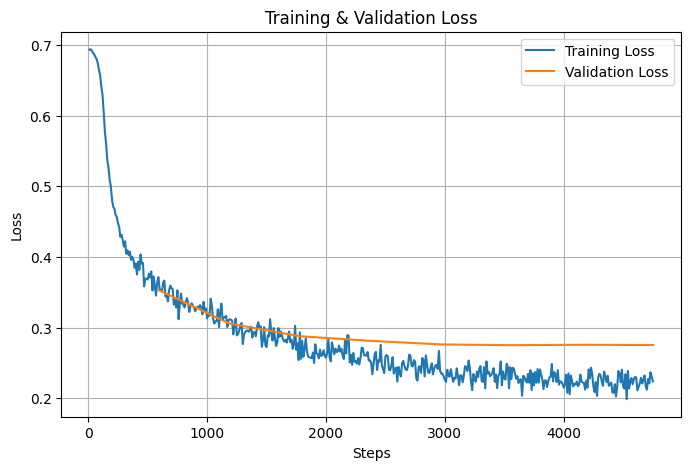

In [21]:
# After training
logs = trainer.state.log_history

# Extract loss per step
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
steps = [log["step"] for log in logs if "loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model.save_pretrained(output_dir)  # saves model + correct config.json
tokenizer.save_pretrained(output_dir)

Configuration saved in ./7k_distil-bert-uncased_Batch12_LRcosine\config.json
Model weights saved in ./7k_distil-bert-uncased_Batch12_LRcosine\model.safetensors
tokenizer config file saved in ./7k_distil-bert-uncased_Batch12_LRcosine\tokenizer_config.json
Special tokens file saved in ./7k_distil-bert-uncased_Batch12_LRcosine\special_tokens_map.json


('./7k_distil-bert-uncased_Batch12_LRcosine\\tokenizer_config.json',
 './7k_distil-bert-uncased_Batch12_LRcosine\\special_tokens_map.json',
 './7k_distil-bert-uncased_Batch12_LRcosine\\vocab.txt',
 './7k_distil-bert-uncased_Batch12_LRcosine\\added_tokens.json',
 './7k_distil-bert-uncased_Batch12_LRcosine\\tokenizer.json')

In [7]:
from sklearn.metrics import f1_score
import numpy as np

# probs: (n_samples, n_classes), from sigmoid(logits)
# labels: (n_samples, n_classes), true binary labels
def optimize_thresholds(probs, labels, thresholds=np.linspace(0.05, 0.95, 19)):
    num_labels = probs.shape[1]
    best_thresholds = np.zeros(num_labels)
    
    for i in range(num_labels):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            preds = (probs[:, i] >= t).astype(int)
            f1 = f1_score(labels[:, i], preds)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds[i] = best_t
        print(f"Label {i}: Best threshold = {best_t:.2f}, F1 = {best_f1:.4f}")
        
    return best_thresholds

def optimize_thresholds_with_precision_constraint(probs, labels, thresholds=np.linspace(0.1, 0.9, 17), min_precision=0.5):
    best_thresholds = []
    for i in range(probs.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for t in thresholds:
            pred = (probs[:, i] >= t).astype(int)
            precision = precision_score(labels[:, i], pred, zero_division=0)
            f1 = f1_score(labels[:, i], pred, zero_division=0)
            if f1 > best_f1 and precision >= min_precision:
                best_f1 = f1
                best_thresh = t
        best_thresholds.append(best_thresh)
        print(f"Label {i}: Best threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")
    return np.array(best_thresholds)

# thresholds = optimize_thresholds_with_precision_constraint(probabilities, labels)

# Apply per-class thresholds to make predictions
# preds = (probabilities >= thresholds).astype(int)

In [21]:
x=np.array([[1, 2, 3],
              [4, 5, 6]])
x[:,1]


array([2, 5])

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, roc_auc_score
import torch
import numpy as np
import pandas as pd


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def evaluate_model_on_test(model_path, test_dataset, threshold=0.5):
    print(f"\n🔍 Evaluating model: {model_path}")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Prepare dataset (if not already)
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    from torch.utils.data import DataLoader
    from transformers import DataCollatorWithPadding

    data_collator = DataCollatorWithPadding(tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=data_collator)

    # Collect predictions
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["labels"].cpu().numpy()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()

            all_probs.append(probs)
            all_labels.append(labels)

    probabilities = np.vstack(all_probs)
    labels = np.vstack(all_labels)
    global thresholds
    thresholds = optimize_thresholds_with_precision_constraint(probabilities, labels)
    preds = (probabilities >= thresholds).astype(int)

    # Compute metrics
    f1 = f1_score(labels, preds, average='samples')
    precision = precision_score(labels, preds, average='samples')
    recall = recall_score(labels, preds, average='samples')
    accuracy = accuracy_score(labels, preds)
    hamming = hamming_loss(labels, preds)
    jaccard = jaccard_score(labels, preds, average='samples')
    hit_rate = (np.logical_and(labels, preds).sum(axis=1) > 0).mean()
    try:
        roc_auc = roc_auc_score(labels, probabilities, average="samples")
    except ValueError:
        roc_auc = np.nan  # Fallback in case a label has no positive samples

    # Create DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['F1 Score', 'Precision', 'Recall', 'Exact Match Accuracy', 'Hamming Loss', 'Jaccard Score', 'Hit Rate', 'ROC AUC'],
        'Value': [f1, precision, recall, accuracy, hamming, jaccard, hit_rate, roc_auc]
    })

    print(metrics_df)
    return metrics_df
model_path = "./7k_distilbert-base-uncased_batch12_LRcosinedecay0.1"  # or any other saved model folder
evaluate_model_on_test(model_path, val_dataset)

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja


loading configuration file ./7k_distilbert-base-uncased_batch12_LRcosinedecay0.1\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Action",
    "1": "Adventure",
    "2": "Comedy",
    "3": "Drama",
    "4": "Fantasy",
    "5": "Historical",
    "6": "Kids",
    "7": "Mecha",
    "8": "Music",
    "9": "Mystery",
    "10": "Romance",
    "11": "School",
    "12": "Sci-Fi",
    "13": "Seinen",
    "14": "Shoujo",
    "15": "Shounen",
    "16": "Slice of Life",
    "17": "Sports",
    "18": "Super Power",
    "19": "Supernatural"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Action": 0,
    "Adventure": 1,
    "Comedy": 2,
    "Drama": 3,
    "Fantasy": 4,
    "Historical": 5,
    "Kids": 6,
    "Mecha": 7,
    "Music": 8,
    "Mystery": 9,
    "Romance": 10,
    "School": 11,
    "Sci-Fi


🔍 Evaluating model: ./7k_distilbert-base-uncased_batch12_LRcosinedecay0.1
Label 0: Best threshold = 0.45, F1 = 0.6957
Label 1: Best threshold = 0.30, F1 = 0.6071
Label 2: Best threshold = 0.25, F1 = 0.6904
Label 3: Best threshold = 0.45, F1 = 0.3851
Label 4: Best threshold = 0.30, F1 = 0.6608
Label 5: Best threshold = 0.25, F1 = 0.5385
Label 6: Best threshold = 0.30, F1 = 0.4706
Label 7: Best threshold = 0.35, F1 = 0.6216
Label 8: Best threshold = 0.25, F1 = 0.6512
Label 9: Best threshold = 0.30, F1 = 0.4673
Label 10: Best threshold = 0.45, F1 = 0.5961
Label 11: Best threshold = 0.40, F1 = 0.6496
Label 12: Best threshold = 0.40, F1 = 0.6724
Label 13: Best threshold = 0.30, F1 = 0.0278
Label 14: Best threshold = 0.20, F1 = 0.3373
Label 15: Best threshold = 0.40, F1 = 0.3153
Label 16: Best threshold = 0.45, F1 = 0.3800
Label 17: Best threshold = 0.20, F1 = 0.7907
Label 18: Best threshold = 0.50, F1 = 0.0000
Label 19: Best threshold = 0.30, F1 = 0.6215


c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 Metric     Value
0              F1 Score  0.559518
1             Precision  0.610519
2                Recall  0.584282
3  Exact Match Accuracy  0.081839
4          Hamming Loss  0.116424
5         Jaccard Score  0.440353
6              Hit Rate  0.875561
7               ROC AUC  0.885552


,Metric,Value
0,F1 Score,0.559518
1,Precision,0.610519
2,Recall,0.584282
3,Exact Match Accuracy,0.081839
4,Hamming Loss,0.116424
5,Jaccard Score,0.440353
6,Hit Rate,0.875561
7,ROC AUC,0.885552


In [29]:
#Test run to find the metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score,roc_auc_score
import numpy as np
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Step 1: Predict on test set
raw_predictions = trainer.predict(test_dataset)
probabilities = sigmoid(raw_predictions.predictions)  # apply sigmoid
preds = (probabilities > thresholds).astype(int)
labels = raw_predictions.label_ids

# Step 2: Compute metrics
f1 = f1_score(labels, preds, average='samples')
precision = precision_score(labels, preds, average='samples')
recall = recall_score(labels, preds, average='samples')
accuracy = accuracy_score(labels, preds)
hamming = hamming_loss(labels, preds)
jaccard = jaccard_score(labels, preds, average='samples')
hit_rate = (np.logical_and(labels, preds).sum(axis=1) > 0).mean()
roc_auc=roc_auc_score(labels,probabilities,average="samples")


# Step 3: Show metrics in a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['F1 Score', 'Precision', 'Recall', 'Exact Match Accuracy', 'Hamming Loss', 'Jaccard Score', 'Hit Rate','ROC_AUC'],
    'Value': [f1, precision, recall, accuracy, hamming, jaccard, hit_rate,roc_auc]
})

print(metrics_df)
display(metrics_df)


***** Running Prediction *****
  Num examples = 749
  Batch size = 12


c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 Metric     Value
0              F1 Score  0.532903
1             Precision  0.585648
2                Recall  0.560314
3  Exact Match Accuracy  0.053405
4          Hamming Loss  0.127770
5         Jaccard Score  0.410610
6              Hit Rate  0.866489
7               ROC_AUC  0.874816


,Metric,Value
0,F1 Score,0.532903
1,Precision,0.585648
2,Recall,0.560314
3,Exact Match Accuracy,0.053405
4,Hamming Loss,0.127770
5,Jaccard Score,0.410610
6,Hit Rate,0.866489
7,ROC_AUC,0.874816


In [30]:
print(thresholds)

[0.3  0.3  0.3  0.45 0.35 0.25 0.25 0.3  0.15 0.2  0.3  0.3  0.4  0.2
 0.5  0.35 0.4  0.2  0.5  0.3 ]


In [27]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, hamming_loss, jaccard_score
)

# ====== Define metrics ======
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_all_metrics(labels, preds):
    return {
        'F1 Score': f1_score(labels, preds, average='samples'),
        'Precision': precision_score(labels, preds, average='samples'),
        'Recall': recall_score(labels, preds, average='samples'),
        'Exact Match Accuracy': accuracy_score(labels, preds),
        'Hamming Loss': hamming_loss(labels, preds),
        'Jaccard Score': jaccard_score(labels, preds, average='samples'),
        'Hit Rate': (np.logical_and(labels, preds).sum(axis=1) > 0).mean()
    }

# ====== Paths and setup ======
model_dir = "./anime-genre-model-distilbert_100"
checkpoint_dirs = sorted([
    os.path.join(model_dir, d)
    for d in os.listdir(model_dir)
    if d.startswith("checkpoint-")
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_dir)  # assuming one tokenizer for all checkpoints
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ====== Prepare DataLoader from pre-tokenized test_dataset ======
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=data_collator)

# ====== Evaluate each checkpoint ======
results = []

for ckpt_path in checkpoint_dirs:
    print(f"Evaluating {ckpt_path}")
    model = AutoModelForSequenceClassification.from_pretrained(ckpt_path)
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels)

    preds = np.vstack(all_preds)
    labels = np.vstack(all_labels)
    binary_preds = (preds >= 0.5).astype(int)

    metrics = compute_all_metrics(labels, binary_preds)
    metrics["Checkpoint"] = os.path.basename(ckpt_path)
    results.append(metrics)

# ====== Show results ======
df = pd.DataFrame(results)
df = df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
pd.set_option("display.precision", 4)
print("\n📊 Evaluation Results for All Checkpoints:")
print(df)


loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja


KeyError: 'F1 Score'

In [25]:
display(df)

,F1 Score,Precision,Recall,Exact Match Accuracy,Hamming Loss,Jaccard Score,Hit Rate,Checkpoint
0,0.4532,0.6249,0.3903,0.0887,0.0902,0.3534,0.7409,checkpoint-5750
1,0.4470,0.6138,0.3872,0.0861,0.0909,0.3478,0.7347,checkpoint-4600
2,0.3903,0.5698,0.3283,0.0763,0.0925,0.3023,0.6531,checkpoint-3450
3,0.3654,0.5384,0.3058,0.0763,0.0950,0.2830,0.6202,checkpoint-2300
4,0.2857,0.4414,0.2335,0.0603,0.1006,0.2195,0.5004,checkpoint-1150


In [5]:
prediction = trainer.predict(test_dataset)



***** Running Prediction *****
  Num examples = 749
  Batch size = 8


c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
prediction.metrics

{'test_loss': 0.2906854748725891,
 'test_f1_samples': 0.4313595616666378,
 'test_precision': 0.6161548731642189,
 'test_recall': 0.36864231673978004,
 'test_jaccard': 0.32835367791976605,
 'test_hit_rate': 0.7236315086782377,
 'test_hamming_loss': 0.11862483311081443,
 'test_exact_match': 0.050734312416555405,
 'test_runtime': 11.1334,
 'test_samples_per_second': 67.275,
 'test_steps_per_second': 8.443}

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# ====== Load model and tokenizer ======
model_path = "./NEW_distilbert-base-uncased"  # path to your trained model

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ====== Your genre labels (same as during training) ======
genre_labels = list(id2label.values())  # or manually define if not accessible

# ====== New example synopsis texts ======
new_synopsis = [
    "A group of heroes sets off on a journey to defeat the demon king and save their world.",
    "Two high school students meet by chance and begin to fall in love amidst school life.",
    "Join Goku and his friends in their adventure to slay all the vampires and monsters that are destroying their world.",
    "The series follows the team's journey through various competitions and challenges, including the Football Frontier International and the threat of a powerful alien force. ",

    """After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse's body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse's soul in the physical realm by binding it to a hulking suit of armor.

The brothers are rescued by their neighbor Pinako Rockbell and her granddaughter Winry. Known as a bio-mechanical engineering prodigy, Winry creates prosthetic limbs for Edward by utilizing "automail," a tough, versatile metal used in robots and combat armor. After years of training, the Elric brothers set off on a quest to restore their bodies by locating the Philosopher's Stone—a powerful gem that allows an alchemist to defy the traditional laws of Equivalent Exchange.

As Edward becomes an infamous alchemist and gains the nickname "Fullmetal," the boys' journey embroils them in a growing conspiracy that threatens the fate of the world.""",

"""Misaki Ayuzawa is a unique phenomenon within Seika High School. In a predominantly male institution, she became the first-ever female student council president through her honesty and diligence. Ever since Misaki got promoted to the position, she has been working tirelessly to ensure a better school life for all girls. Despite that, Misaki is very strict with the boys, which has earned her the title "Demon President."

One day, after hearing a girl cry in the hallway, Misaki encounters Takumi Usui—the most popular boy in the school—as he rejects a love confession. Enraged at what she is seeing, Misaki reprimands him for making the girl cry. However, Usui is indifferent and brushes it off as nothing.

Unexpectedly, Misaki soon runs into Usui again, but this time when she is working at a maid cafe! Embarrassed that someone has found out about her secret occupation, Misaki promises herself not to let Usui destroy her reputation. However, the mysterious boy now begins to visit the same cafe regularly to observe and tease Misaki. When push comes to shove, will Usui still be able to keep the president's secret?
""",
"Shuramaru is hated and feared by the villagers for his unusual powers. He thinks he is human, but... is he?  (Source: AniDB)",
"The daily life of the Motsumoto family. The three sisters, Fuu, Suu, and Chii, follow what happens on a daily basis. Mother and Father have to deal with them sometimes, but they're used to it.",
"A prequel TV series setting up for the feature film.  G.G. Bond's father while exploring ruins gets sucked into a dimension of evil through the Dark Gate. He is bestowed power and knowledge and becomes corrupted as the King of Darkness. Ancient monsters are sent through the cracks of the gate to attack G.G. Bond and his team as the 5 elemental powers are stronger than the King of Darkness. By weakening the team, only then can the King of Darkness forcibly open the gate to unless a reign of terror on the Fairy Tale world.",
"Spring. Far from the city, time flows peacefully in this rural town. As the cherry blossoms scatter in the wind, a young man named Yu Narukami steps off the train at Yasoinaba Station. Yu has come to this town, where his uncle lives, for family reasons; he will be transferring into the local high school, Yasogami High. And so begins his school life... The shopping mall after school. A series of murders taking place in town. The Midnight Channel, airing late at night.... What lies in store for Yu and his friends ‘this time around?  (Source: Aniplex USA)",
"The tournament of football has finally commenced in Japan and it is now time for Hashiro to shine. Join him in his adventure with his highschool friends to dominate the tournament.",
"""The stage is Ayanagi City, a city near the Japan Sea. It is a futuristic city that was built to carry out the recovery from the calamity caused by the "Apathy Syndrome" ten years previous. High school student Shin Kanzato with his little brother Jun, meet with their elder brother Ryou, who is the chief of the Ayanagi City Police, again after ten years. At that time, a series of strange incidents happen in Ayanagi City such as the crew of a submarine that suddenly disappears while in their submarine, or a spiritless symptom which disturbs the world after ten years, or the case of the inside out corpse where a student took on a cruel appearance. Ryou tracks down the organization behind the string of incidents, and having become involved in the incidents, Shin awakens the "Persona."  (Source: Wikipedia)""",
"The Dragon Ball series follows the Saiyan warrior Son Goku as he grows from a child into a powerful defender of Earth, facing increasingly stronger enemies and training to become the strongest. The core plot revolves around Goku's journey to gather the Dragon Balls, which grant wishes when all seven are collected, and his defense of Earth from various threats, including alien conquerors, powerful androids, and magical beings",
"The story centers on Otarou, a creature themed around dirt known as a yogoremon. It and other yogoremon ask the meaning of words and explain negative terms in positive ways.  (Source: ANN)"
]

# ====== Tokenize and predict ======
inputs = tokenizer(new_synopsis, padding=True, truncation=True, return_tensors="pt", max_length=512)
inputs = {key: val.to(device) for key, val in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()



# ====== Post-process predictions ======
threshold = 0.5
predictions = (probs >= thresholds).astype(int)

# ====== Display results ======
for i, synopsis in enumerate(new_synopsis):
    predicted_genres = [genre_labels[j] for j, pred in enumerate(predictions[i]) if pred == 1]
    print(f"Synopsis {i+1}: {synopsis}")
    print(f"Predicted Genres: {predicted_genres}\n")


loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja


loading configuration file ./NEW_distilbert-base-uncased\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Action",
    "1": "Adventure",
    "2": "Comedy",
    "3": "Drama",
    "4": "Fantasy",
    "5": "Historical",
    "6": "Kids",
    "7": "Mecha",
    "8": "Music",
    "9": "Mystery",
    "10": "Romance",
    "11": "School",
    "12": "Sci-Fi",
    "13": "Seinen",
    "14": "Shoujo",
    "15": "Shounen",
    "16": "Slice of Life",
    "17": "Sports",
    "18": "Super Power",
    "19": "Supernatural"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Action": 0,
    "Adventure": 1,
    "Comedy": 2,
    "Drama": 3,
    "Fantasy": 4,
    "Historical": 5,
    "Kids": 6,
    "Mecha": 7,
    "Music": 8,
    "Mystery": 9,
    "Romance": 10,
    "School": 11,
    "Sci-Fi": 12,
    "Seinen": 13,

Synopsis 1: A group of heroes sets off on a journey to defeat the demon king and save their world.
Predicted Genres: ['Action', 'Adventure', 'Comedy', 'Fantasy']

Synopsis 2: Two high school students meet by chance and begin to fall in love amidst school life.
Predicted Genres: ['Romance', 'School']

Synopsis 3: Join Goku and his friends in their adventure to slay all the vampires and monsters that are destroying their world.
Predicted Genres: ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Kids']

Synopsis 4: The series follows the team's journey through various competitions and challenges, including the Football Frontier International and the threat of a powerful alien force. 
Predicted Genres: ['Action', 'Sci-Fi']

Synopsis 5: After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother 

Configuration saved in ./anime-genre-model_balanced\config.json
Model weights saved in ./anime-genre-model_balanced\model.safetensors
tokenizer config file saved in ./anime-genre-model_balanced\tokenizer_config.json
Special tokens file saved in ./anime-genre-model_balanced\special_tokens_map.json


('./anime-genre-model_balanced\\tokenizer_config.json',
 './anime-genre-model_balanced\\special_tokens_map.json',
 './anime-genre-model_balanced\\vocab.txt',
 './anime-genre-model_balanced\\added_tokens.json',
 './anime-genre-model_balanced\\tokenizer.json')

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Step 1: Predict on test set
predictions = trainer.predict(test_dataset)
preds = (predictions.predictions > 0.5).astype(int)
labels = predictions.label_ids

# Step 2: Initialize containers
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
genre_names = []

# Step 3: Compute metrics per class
for i, genre in id2label.items():
    genre_preds = preds[:, i]
    genre_labels = labels[:, i]

    accuracy = accuracy_score(genre_labels, genre_preds)
    precision = precision_score(genre_labels, genre_preds, zero_division=0)
    recall = recall_score(genre_labels, genre_preds, zero_division=0)
    f1 = f1_score(genre_labels, genre_preds, zero_division=0)

    genre_names.append(genre)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"{genre}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Step 4: Save to DataFrame & CSV
df_metrics = pd.DataFrame({
    "Genre": genre_names,
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1-Score": f1_list
})

df_metrics.to_csv("per_class_metrics.csv", index=False)
print("\n✅ Metrics saved to per_class_metrics.csv")


***** Running Prediction *****
  Num examples = 749
  Batch size = 8


c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Action: Accuracy=0.7623, Precision=0.7355, Recall=0.4542, F1=0.5616
Adventure: Accuracy=0.7877, Precision=0.8000, Recall=0.2292, F1=0.3563
Comedy: Accuracy=0.7196, Precision=0.8231, Recall=0.3967, F1=0.5354
Drama: Accuracy=0.7931, Precision=0.9000, Recall=0.1053, F1=0.1885
Fantasy: Accuracy=0.8211, Precision=0.8119, Recall=0.4162, F1=0.5503
Historical: Accuracy=0.9252, Precision=1.0000, Recall=0.1111, F1=0.2000
Kids: Accuracy=0.9105, Precision=0.0000, Recall=0.0000, F1=0.0000
Mecha: Accuracy=0.9279, Precision=0.7333, Recall=0.1803, F1=0.2895
Music: Accuracy=0.9453, Precision=0.0000, Recall=0.0000, F1=0.0000
Mystery: Accuracy=0.9279, Precision=1.0000, Recall=0.0182, F1=0.0357
Romance: Accuracy=0.8718, Precision=0.9091, Recall=0.2439, F1=0.3846
School: Accuracy=0.8945, Precision=0.7500, Recall=0.1978, F1=0.3130
Sci-Fi: Accuracy=0.8879, Precision=0.8393, Recall=0.5875, F1=0.6912
Seinen: Accuracy=0.9226, Precision=0.0000, Recall=0.0000, F1=0.0000
Shoujo: Accuracy=0.9319, Precision=0.0000, 

In [14]:
roc_auc_per_class = roc_auc_score(labels, preds, average=None)

for label, auc in zip(genre_labels, roc_auc_per_class):
    print(f"{label}: ROC AUC = {auc:.4f}")

0.0: ROC AUC = 0.6859
0.0: ROC AUC = 0.6047
0.0: ROC AUC = 0.6691
0.0: ROC AUC = 0.5509
0.0: ROC AUC = 0.6909
0.0: ROC AUC = 0.5556
0.0: ROC AUC = 0.5000
1.0: ROC AUC = 0.5873
0.0: ROC AUC = 0.5000
0.0: ROC AUC = 0.5091
0.0: ROC AUC = 0.6196
0.0: ROC AUC = 0.5943
0.0: ROC AUC = 0.7785
1.0: ROC AUC = 0.5000
0.0: ROC AUC = 0.5000
0.0: ROC AUC = 0.5000
0.0: ROC AUC = 0.5000
0.0: ROC AUC = 0.7030
0.0: ROC AUC = 0.5000
1.0: ROC AUC = 0.5235


In [15]:
display(df_metrics)

,Genre,Accuracy,Precision,Recall,F1-Score
0,Action,0.762350,0.735484,0.454183,0.561576
1,Adventure,0.787717,0.800000,0.229167,0.356275
2,Comedy,0.719626,0.823129,0.396721,0.535398
3,Drama,0.793057,0.900000,0.105263,0.188482
4,Fantasy,0.821095,0.811881,0.416244,0.550336
5,Historical,0.925234,1.000000,0.111111,0.200000
6,Kids,0.910547,0.000000,0.000000,0.000000
7,Mecha,0.927904,0.733333,0.180328,0.289474
8,Music,0.945260,0.000000,0.000000,0.000000
9,Mystery,0.927904,1.000000,0.018182,0.035714


In [16]:
import numpy as np

# Total true occurrences per genre
genre_counts = labels.sum(axis=0)
for i, genre in id2label.items():
    print(f"{genre}: {int(genre_counts[i])} true instances in test set")


Action: 251 true instances in test set
Adventure: 192 true instances in test set
Comedy: 305 true instances in test set
Drama: 171 true instances in test set
Fantasy: 197 true instances in test set
Historical: 63 true instances in test set
Kids: 67 true instances in test set
Mecha: 61 true instances in test set
Music: 41 true instances in test set
Mystery: 55 true instances in test set
Romance: 123 true instances in test set
School: 91 true instances in test set
Sci-Fi: 160 true instances in test set
Seinen: 58 true instances in test set
Shoujo: 51 true instances in test set
Shounen: 126 true instances in test set
Slice of Life: 115 true instances in test set
Sports: 39 true instances in test set
Super Power: 45 true instances in test set
Supernatural: 97 true instances in test set


In [17]:
df_test[df_test["genres"].apply(lambda genres: "Super Power" in genres)]

,synopsis,genres,labels
8,A more educational season of GG Bond. This sea...,"[Historical, Kids, Sci-Fi, Super Power]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
42,"The anime will be a ""surreal comedy"" that emph...","[Comedy, Super Power]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61,Nano Invaders follows the eye-popping adventur...,"[Action, Adventure, Shounen, Super Power]","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
76,After fighting to free the game of soccer in J...,"[Shounen, Sports, Super Power]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
88,This gag comedy series focused on the adventur...,"[Comedy, Sci-Fi, Shounen, Super Power]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
161,"A golden warrior wearing a cape and a scepter,...","[Action, Sci-Fi, Super Power]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
186,"Kitarou, a ghost, spends his afterlife helping...","[Adventure, Super Power, Supernatural]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
229,"Ultra B (UB), is a small child from outer spac...","[Comedy, Super Power]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
268,"The stage is Ayanagi City, a city near the Jap...","[Action, Sci-Fi, Super Power]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
284,"Despite their differences in position, three m...","[Action, Mystery, Seinen, Super Power, Superna...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [55]:
predicted_counts = preds.sum(axis=0)
for i, genre in id2label.items():
    print(f"{genre}: {int(predicted_counts[i])} predicted instances")


Action: 414 predicted instances
Adventure: 358 predicted instances
Comedy: 549 predicted instances
Demons: 179 predicted instances
Drama: 389 predicted instances
Ecchi: 237 predicted instances
Fantasy: 336 predicted instances
Harem: 206 predicted instances
Hentai: 163 predicted instances
Historical: 121 predicted instances
Horror: 132 predicted instances
Kids: 127 predicted instances
Mecha: 152 predicted instances
Military: 116 predicted instances
Music: 73 predicted instances
Mystery: 183 predicted instances
Other: 307 predicted instances
Parody: 107 predicted instances
Romance: 398 predicted instances
School: 314 predicted instances
Sci-Fi: 247 predicted instances
Seinen: 226 predicted instances
Shoujo: 301 predicted instances
Shounen: 305 predicted instances
Slice of Life: 297 predicted instances
Sports: 70 predicted instances
Super Power: 137 predicted instances
Supernatural: 261 predicted instances


In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# ====== Load model and tokenizer ======
model_path = "./anime-genre-roberta"  # path to your trained model

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ====== Your genre labels (same as during training) ======
genre_labels = list(id2label.values())  # or manually define if not accessible

# ====== New example synopsis texts ======
new_synopsis = [
    "A group of heroes sets off on a journey to defeat the demon king and save their world.",
    "Two high school students meet by chance and begin to fall in love amidst school life.",
    "Join Goku and his friends in their adventure to slay all the vampires and monsters that are destroying their world.",
    "The series follows the team's journey through various competitions and challenges, including the Football Frontier International and the threat of a powerful alien force. ",

    """After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse's body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse's soul in the physical realm by binding it to a hulking suit of armor.

The brothers are rescued by their neighbor Pinako Rockbell and her granddaughter Winry. Known as a bio-mechanical engineering prodigy, Winry creates prosthetic limbs for Edward by utilizing "automail," a tough, versatile metal used in robots and combat armor. After years of training, the Elric brothers set off on a quest to restore their bodies by locating the Philosopher's Stone—a powerful gem that allows an alchemist to defy the traditional laws of Equivalent Exchange.

As Edward becomes an infamous alchemist and gains the nickname "Fullmetal," the boys' journey embroils them in a growing conspiracy that threatens the fate of the world.""",

"""Misaki Ayuzawa is a unique phenomenon within Seika High School. In a predominantly male institution, she became the first-ever female student council president through her honesty and diligence. Ever since Misaki got promoted to the position, she has been working tirelessly to ensure a better school life for all girls. Despite that, Misaki is very strict with the boys, which has earned her the title "Demon President."

One day, after hearing a girl cry in the hallway, Misaki encounters Takumi Usui—the most popular boy in the school—as he rejects a love confession. Enraged at what she is seeing, Misaki reprimands him for making the girl cry. However, Usui is indifferent and brushes it off as nothing.

Unexpectedly, Misaki soon runs into Usui again, but this time when she is working at a maid cafe! Embarrassed that someone has found out about her secret occupation, Misaki promises herself not to let Usui destroy her reputation. However, the mysterious boy now begins to visit the same cafe regularly to observe and tease Misaki. When push comes to shove, will Usui still be able to keep the president's secret?
""",
"Shuramaru is hated and feared by the villagers for his unusual powers. He thinks he is human, but... is he?  (Source: AniDB)",
"The daily life of the Motsumoto family. The three sisters, Fuu, Suu, and Chii, follow what happens on a daily basis. Mother and Father have to deal with them sometimes, but they're used to it.",
"A prequel TV series setting up for the feature film.  G.G. Bond's father while exploring ruins gets sucked into a dimension of evil through the Dark Gate. He is bestowed power and knowledge and becomes corrupted as the King of Darkness. Ancient monsters are sent through the cracks of the gate to attack G.G. Bond and his team as the 5 elemental powers are stronger than the King of Darkness. By weakening the team, only then can the King of Darkness forcibly open the gate to unless a reign of terror on the Fairy Tale world.",
"Spring. Far from the city, time flows peacefully in this rural town. As the cherry blossoms scatter in the wind, a young man named Yu Narukami steps off the train at Yasoinaba Station. Yu has come to this town, where his uncle lives, for family reasons; he will be transferring into the local high school, Yasogami High. And so begins his school life... The shopping mall after school. A series of murders taking place in town. The Midnight Channel, airing late at night.... What lies in store for Yu and his friends ‘this time around?  (Source: Aniplex USA)",
"""For some people, high school represents the opportunity for a fresh start. You can take new classes and make new friends. For Souichiro Nagi and Bob Makihara, though, high school means something different: the chance to become the top fighters in the entire student body! Too bad Toudou Academy is the hardest possible place to realize their dreams. Their new high school is no ordinary academic institution. Rather than concentrating on classic subjects like math and science, Toudou Academy was created for the sole purpose of reviving the martial arts in Japan!  As a result, Souichiro's aspirations to become top dog are cut short when he runs afoul of Masataka Takayanagi and Maya Natsume. The two upperclassmen easily stop the freshmen duo's rampage across school, but rather than serving as a deterrent, it only stokes their competitive fire. What kind of monstrous fighters attend Toudou Academy? Are there any stronger than Masataka and Maya? And why in the world is Maya's younger sister stalking Souichiro? Learn the answers to these questions and more in !"""
]

# ====== Tokenize and predict ======
inputs = tokenizer(new_synopsis, padding=True, truncation=True, return_tensors="pt", max_length=512)
inputs = {key: val.to(device) for key, val in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()

# ====== Hybrid Post-processing ======
threshold = 0.5
top_k = 2
final_predictions = np.zeros_like(probs, dtype=int)

for i, row in enumerate(probs):
    confident = row >= threshold
    if confident.any():
        final_predictions[i] = confident.astype(int)
    else:
        top_indices = row.argsort()[-top_k:]
        final_predictions[i, top_indices] = 1

# ====== Display results ======
for i, synopsis in enumerate(new_synopsis):
    predicted_genres = [genre_labels[j] for j, pred in enumerate(final_predictions[i]) if pred == 1]
    print(f"📝 Synopsis {i+1}:\n{synopsis}\n")
    print(f"🎯 Predicted Genres: {predicted_genres}\n{'-'*80}")

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja
loading configuration file ./anime-genre-roberta\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Action",
    "1": "Adventure",
    "2": "Comedy",
    "3": "Demons",
    "4": "Drama",
    "5": "Ecchi",
    "6": "Fantasy",
    "7": "Harem",
    "8": "Hentai",
    "9": "Historical",
    "10": "Horror",
    "11": "Kids",
    "12": "Mecha",
    "13": "Military",
    "14": "Music",
    "15": "Mystery",
    "16": "Other",
    "17": "Parody",
    "18": "Romance",
    "19": "School",
    "20": "Sci-Fi",
    "21": "Seine

📝 Synopsis 1:
A group of heroes sets off on a journey to defeat the demon king and save their world.

🎯 Predicted Genres: ['Action', 'Adventure', 'Comedy', 'Fantasy']
--------------------------------------------------------------------------------
📝 Synopsis 2:
Two high school students meet by chance and begin to fall in love amidst school life.

🎯 Predicted Genres: ['Romance', 'School']
--------------------------------------------------------------------------------
📝 Synopsis 3:
Join Goku and his friends in their adventure to slay all the vampires and monsters that are destroying their world.

🎯 Predicted Genres: ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Shounen']
--------------------------------------------------------------------------------
📝 Synopsis 4:
The series follows the team's journey through various competitions and challenges, including the Football Frontier International and the threat of a powerful alien force. 

🎯 Predicted Genres: ['Action', 'Sports']
------------

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Step 1: Predict on test set
predictions = trainer.predict(test_dataset)
probs = predictions.predictions
labels = predictions.label_ids

# Step 2: Threshold-based predictions only (no fallback)
threshold = 0.5
preds = (probs >= thresholds).astype(int)

# Step 3: Count how many samples had no predictions or no ground truth
num_no_pred = np.sum(preds.sum(axis=1) == 0)
num_no_true = np.sum(labels.sum(axis=1) == 0)

print(f"\n⚠️ {num_no_pred} samples had NO genres predicted.")
print(f"📭 {num_no_true} samples had NO true labels in the dataset.")

# Step 4: Per-class metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
genre_names = []

for i, genre in id2label.items():
    genre_preds = preds[:, i]
    genre_labels = labels[:, i]

    accuracy = accuracy_score(genre_labels, genre_preds)
    precision = precision_score(genre_labels, genre_preds, zero_division=0)
    recall = recall_score(genre_labels, genre_preds, zero_division=0)
    f1 = f1_score(genre_labels, genre_preds, zero_division=0)

    genre_names.append(genre)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"{genre}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Step 5: Save to DataFrame & CSV
df_metrics = pd.DataFrame({
    "Genre": genre_names,
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1-Score": f1_list
})

df_metrics.to_csv("per_class_metrics.csv", index=False)
print("\n✅ Metrics saved to per_class_metrics.csv")



***** Running Prediction *****
  Num examples = 749
  Batch size = 8


c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



⚠️ 199 samples had NO genres predicted.
📭 0 samples had NO true labels in the dataset.
Action: Accuracy=0.7770, Precision=0.7188, Recall=0.5498, F1=0.6230
Adventure: Accuracy=0.7917, Precision=0.7432, Recall=0.2865, F1=0.4135
Comedy: Accuracy=0.7236, Precision=0.7917, Recall=0.4361, F1=0.5624
Drama: Accuracy=0.7931, Precision=0.8333, Recall=0.1170, F1=0.2051
Fantasy: Accuracy=0.8264, Precision=0.7913, Recall=0.4619, F1=0.5833
Historical: Accuracy=0.9292, Precision=1.0000, Recall=0.1587, F1=0.2740
Kids: Accuracy=0.9105, Precision=0.0000, Recall=0.0000, F1=0.0000
Mecha: Accuracy=0.9319, Precision=0.6923, Recall=0.2951, F1=0.4138
Music: Accuracy=0.9453, Precision=0.0000, Recall=0.0000, F1=0.0000
Mystery: Accuracy=0.9292, Precision=1.0000, Recall=0.0364, F1=0.0702
Romance: Accuracy=0.8718, Precision=0.7872, Recall=0.3008, F1=0.4353
School: Accuracy=0.8945, Precision=0.7000, Recall=0.2308, F1=0.3471
Sci-Fi: Accuracy=0.8945, Precision=0.8403, Recall=0.6250, F1=0.7168
Seinen: Accuracy=0.9226